In [1]:
import uproot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
from sklearn import metrics

In [3]:
sys.path.append('/home/nprouse/WatChMaL/WatChMaL')
import analysis.event_utils as ev

In [4]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-']# note that the order corresponds to labels 0, 1, 2, 3

# Preparing data

## Get true particle data from h5 file

In [5]:
# get indices of test events
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/index_lists/2class_e_gamma/IWCD_mPMT_Short_2_class_eg_9M_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']

In [6]:
# open h5 file and get data for test events
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

## Get fiTQun data from files

In [7]:
# create dictionaries to fill with fitqun data for each particle type
flag_e = {}
flag_mu = {}
flag_pi0 = {}
e_nll = {}
mu_nll = {}
pi0_nll = {}
reco_mom_e = {}
reco_mom_mu = {}
reco_mom_pi0 = {}
reco_pos_e = {}
reco_dir_e = {}
pi0mass = {}
particles = {}
totq = {}

In [8]:
# get the data from the fitqun files
fq_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/"
for p in particle_names:
    # open the fiTQun TTree from the file with uproot
    fq = uproot.open(fq_path+f"IWCD_mPMT_Short_{p}_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root")['fiTQun']
    # extract each branch of the TTree fom the ROOT file into a numpy array, placed in the dictionaries
    flag_e[p] = np.array(fq['fq1rpcflg'].array()[:,0,1])
    flag_mu[p] = np.array(fq['fq1rpcflg'].array()[:,0,2])
    flag_pi0[p] = np.array(fq['fqpi0pcflg'].array()[:,0])
    e_nll[p] = np.array(fq['fq1rnll'].array()[:,0,1])
    mu_nll[p] = np.array(fq['fq1rnll'].array()[:,0,2])
    pi0_nll[p] = np.array(fq['fqpi0nll'].array()[:,0])
    reco_mom_e[p] = np.array(fq['fq1rmom'].array()[:,0,1])
    reco_mom_mu[p] = np.array(fq['fq1rmom'].array()[:,0,2])
    reco_mom_pi0[p] = np.array(fq['fqpi0momtot'].array()[:,0])
    reco_pos_e[p] = np.array(fq['fq1rpos'].array()[:,0,1,:])
    reco_dir_e[p] = np.array(fq['fq1rdir'].array()[:,0,1,:])
    pi0mass[p] = np.array(fq['fqpi0mass'].array()[:,0])
    totq[p] = np.array(fq['fqtotq'].array()[:,0])
#     the labels are just 0, 1, 2, or 3 based on which particle it is, repeated for the number of events
    particles[p] = np.repeat(particle_names.index(p), fq.num_entries)

In [9]:
# create arrays stacking together the particles
# the order of the particles in the test set of the h5 file is [e-, mu-, gamma, pi0]
particle_order = [particle_names[i] for i in h5_labels[::1200000]] #['e-', 'mu-', 'gamma', 'pi0']
fq_flag_e = np.concatenate([flag_e[i] for i in particle_order])
fq_flag_mu = np.concatenate([flag_mu[i] for i in particle_order])
fq_flag_pi0 = np.concatenate([flag_pi0[i] for i in particle_order])
fq_e_nll = np.concatenate([e_nll[i] for i in particle_order])
fq_mu_nll = np.concatenate([mu_nll[i] for i in particle_order])
fq_pi0_nll = np.concatenate([pi0_nll[i] for i in particle_order])
fq_reco_mom_e = np.concatenate([reco_mom_e[i] for i in particle_order])
fq_reco_mom_mu = np.concatenate([reco_mom_mu[i] for i in particle_order])
fq_reco_mom_pi0 = np.concatenate([reco_mom_pi0[i] for i in particle_order])
fq_reco_pos_e = np.concatenate([reco_pos_e[i] for i in particle_order])
fq_reco_dir_e = np.concatenate([reco_dir_e[i] for i in particle_order])
fq_pi0mass = np.concatenate([pi0mass[i] for i in particle_order])
fq_particles = np.concatenate([particles[i] for i in particle_order])
fq_totq = np.concatenate([totq[i] for i in particle_order])

## Find the fiTQun events corresponding to the test set
For the IWCD mPMT e/mu/gamma/pi0 data, there are events missing from the h5 digihits file (used for training and testing) that are not missing from the fiTQun set, so we need to find how to match them up properly. We use the following to match them up:
- Each event in the h5 file has a `label` (particle type), a `root_file` and a `event_id`
- The events in the h5 file are ordered by `label` then `root_file` then `event_id`
- The fiTQun files have all events for one particle type, ordered by `root_file`, then by `event_id`
- Each `root_file` originally has exactly 3000 events in the fiTQun file
- The `event_id`s in for each root file in the fiTQun file go consecutively from 0 to 2999
- The h5 file has a subset of the events in the fiTQun files, and has at least one event from every `root_file`

So we loop through the h5 file events, check the `label` to find which particle it is to choose the corresponding fitqun file, check the `root_file`, if it's the same as the previous then we compare to previous `event_id` and if there's a jump then we skip [new `event_id` minus old `event_id`+1] events in the fiTQun files. If it's a new `root_file` then we skip [new `event_id` plus 3000 minus old `event_id`+1].

Or, we do it more efficiently by adding up offsets by particle type, root file and event_id, because we know:
- There are 400 `root_files` included in the test set for each particle
- There are 3000 `event_id`s running from 0 to 2999 for each `root_file`
So, if we index the `root_files` from 0 to 399 for particle 0, 400 to 799 for particle 1, and so on, then the offset is just `3000*[root_file_index] + [event_id]`

In [10]:
# create dictionary with keys of the unique root_files
root_file_index = dict.fromkeys(h5_root_files)
# update the values to be ascending order
root_file_index.update((k, i) for i, k in enumerate(root_file_index))

In [11]:
root_file_indices = np.vectorize(root_file_index.__getitem__)(h5_root_files)
h5_fq_offsets = 3000*root_file_indices + h5_event_ids

In [12]:
h5_flag_e = fq_flag_e[h5_fq_offsets]
h5_flag_mu = fq_flag_mu[h5_fq_offsets]
h5_flag_pi0 = fq_flag_pi0[h5_fq_offsets]
h5_e_nll = fq_e_nll[h5_fq_offsets]
h5_mu_nll = fq_mu_nll[h5_fq_offsets]
h5_pi0_nll = fq_pi0_nll[h5_fq_offsets]
h5_reco_mom_e = fq_reco_mom_e[h5_fq_offsets]
h5_reco_mom_mu = fq_reco_mom_mu[h5_fq_offsets]
h5_reco_mom_pi0 = fq_reco_mom_pi0[h5_fq_offsets]
h5_reco_pos_e = fq_reco_pos_e[h5_fq_offsets]
h5_reco_dir_e = fq_reco_dir_e[h5_fq_offsets]
h5_pi0mass = fq_pi0mass[h5_fq_offsets]
# h5_particles = fq_particles[h5_fq_offsets]
h5_totq = fq_totq[h5_fq_offsets]

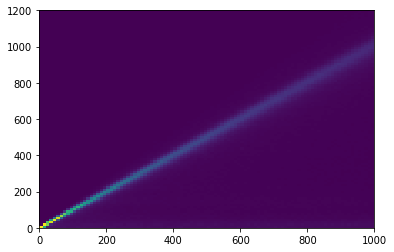

In [13]:
# check gammas seem to be matched right
p = plt.hist2d(h5_energies[h5_labels==0], h5_reco_mom_e[h5_labels==0], bins=100, range=[[0,1000],[0,1200]])

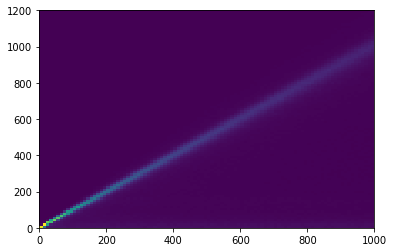

In [14]:
# check electrons seem to be matched right
p = plt.hist2d(h5_energies[h5_labels==1], h5_reco_mom_e[h5_labels==1], bins=100, range=[[0,1000],[0,1200]])

# Plotting fiTQun and ResNet performance

## Load ResNet results

In [15]:
short_locs = [ 
         '/home/mittal41/WatChMaL/outputs/2021-12-12/00-59-06/outputs',      
         '/home/mittal41/WatChMaL/outputs/2021-12-12/05-56-32/outputs',            
]

legend = ["tbs 8192, vbs ebs 16384, lr=0.001"]*3+['4-class']
colors = ["#ff0000", "#ff0000", "#ff0000", "blue"]


In [18]:
# Using the newer version of the WatChMaL code, we need to match up the events correctly
# in the older version, it always matched up because we always used the same events.
# Set is_new to true for all training runs except when using old results (before Nov.2021).

is_new=[True]*4
n_classes = 2
softmaxes = [np.zeros((test_idxs.shape[0],n_classes)) for loc in short_locs]
indices = [np.load(f'{loc}/indices.npy') for loc in short_locs]
N = len(short_locs)
for i in range(N):
    if is_new[i]:
        # match up indices from output to indices in test_idxs
        intersection = np.intersect1d(indices[i], test_idxs, return_indices=True)
        softmaxes[i][intersection[2]] = np.load(f'{short_locs[i]}/softmax.npy')[intersection[1]]
    else:
        softmaxes[i][indices[i]] = np.load(f'{short_locs[i]}/softmax.npy')

## Set up plotting style

In [19]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)

## Make some cuts to select the events of interest

In [20]:
towall = ev.towall(h5_positions, h5_angles)
dwall = ev.dwall(h5_positions)
momentum = ev.momentum(h5_energies, h5_labels)

towall_cut = towall > 0.63*np.log(momentum) # only for electrons
dwall_cut = dwall > 0.5
reco_cut = (h5_flag_e == 0) & (h5_flag_mu == 0)
od_veto_cut = (h5_vetos == 0)

# select the true electron events that pass the cuts
gammas = (h5_labels==0) & towall_cut & dwall_cut & reco_cut & od_veto_cut

# select the true electron events that pass the cuts
electrons = (h5_labels==1) & towall_cut & dwall_cut & reco_cut & od_veto_cut


# all events passing cuts
eg_cut = electrons | gammas
ge_cut = eg_cut

## electron vs gamma

### ROC curve for electron signal vs gamma rejection

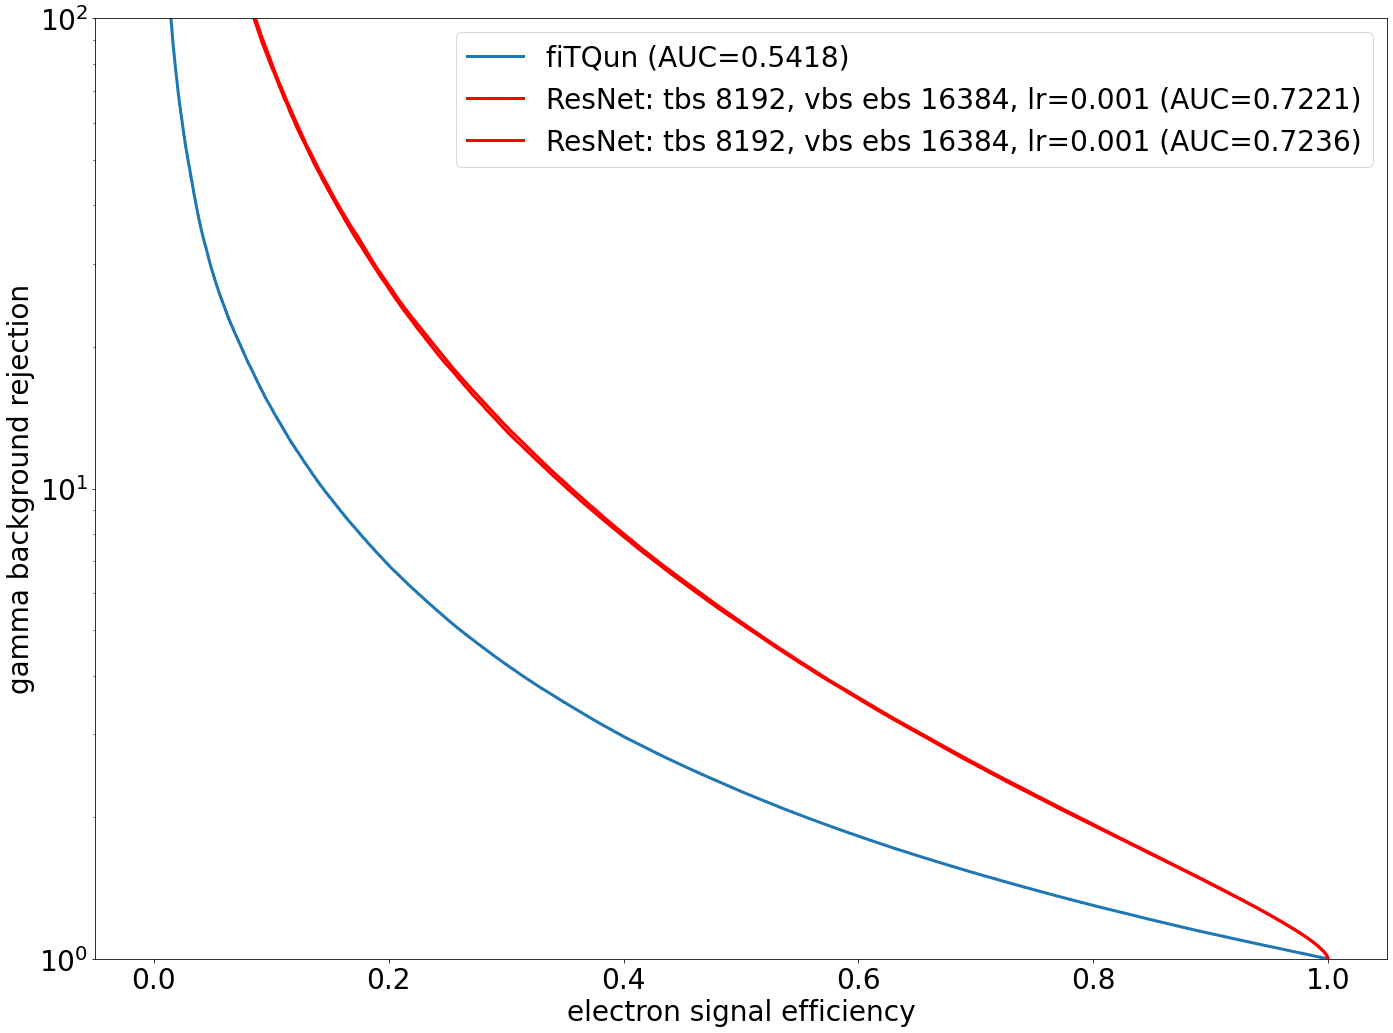

In [22]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
eg_nll = h5_e_nll-h5_mu_nll
# the electron-like discriminator for ResNet is:
# [electron softmax]/([electron softmax] + [gamma softmax])
eg_elike = [softmaxes[i][:,1]/(softmaxes[i][:,1] + softmaxes[i][:,0]) for i in range(N)]

# get the true and false positives
eg_fq_roc_fpr, eg_fq_roc_tpr, _ = metrics.roc_curve(h5_labels[eg_cut]==1, eg_nll[eg_cut])

eg_rn_roc_fpr, eg_rn_roc_tpr = [],[]
for i in range(N):
    fpr,tpr, _ = metrics.roc_curve(h5_labels[eg_cut]==1, eg_elike[i][eg_cut])
    eg_rn_roc_fpr.append(fpr)
    eg_rn_roc_tpr.append(tpr)
    
# get the AUC
eg_fq_auc = metrics.auc(eg_fq_roc_fpr, eg_fq_roc_tpr)
eg_rn_auc = [metrics.auc(eg_rn_roc_fpr[i], eg_rn_roc_tpr[i]) for i in range(N)]

with np.errstate(divide='ignore'):
    eg_fq_bgr = 1/eg_fq_roc_fpr
    eg_rn_bgr = [1/eg_rn_roc_fpr[i] for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(eg_fq_roc_tpr, eg_fq_bgr, label=f"fiTQun (AUC={eg_fq_auc:.4f})", lw=3)

for i in range(N):
    ax.plot(eg_rn_roc_tpr[i], eg_rn_bgr[i], label=f"ResNet: {legend[i]} (AUC={eg_rn_auc[i]:.4f})",color=colors[i],lw=3)

ax.set_xlabel("electron signal efficiency")
ax.set_ylabel("gamma background rejection")
ax.set_yscale('log')
ax.set_ylim((1,100))
# ax.set_xlim((0.8,1))
ax.legend()
fig.tight_layout()
#plt.savefig('2_class_results/roc1.jpg',bbox_inches='tight', dpi=150)


### ROC curve for gamma signal vs electron rejection

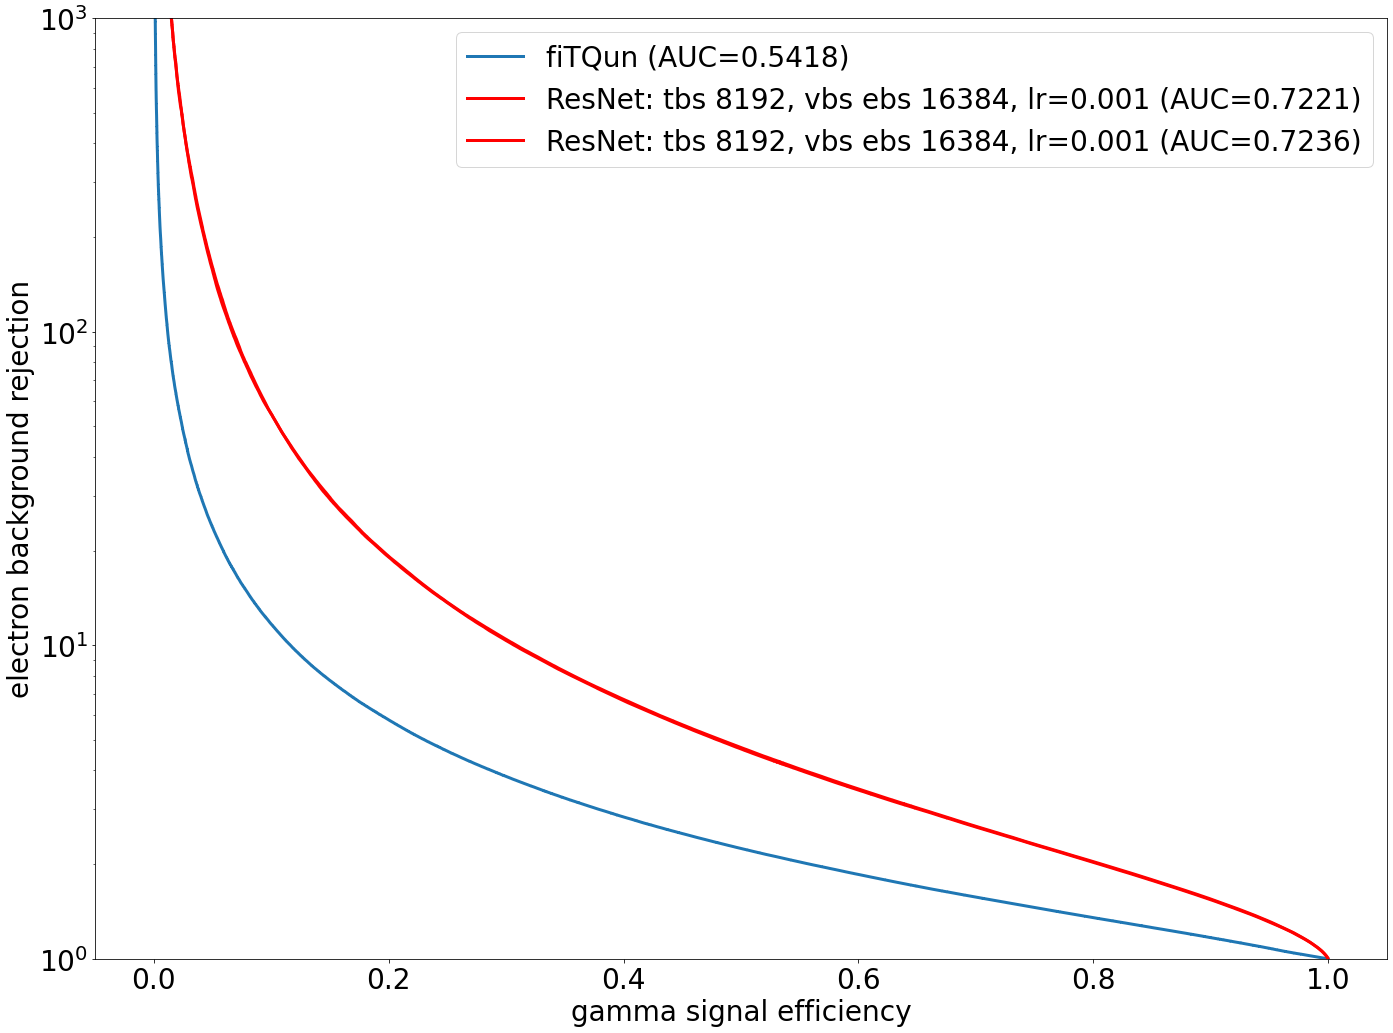

In [23]:
# the electron-like discriminator is the ngeative log-likelihood difference for fiTQun (es are more mu-like...)
ge_nll = h5_mu_nll-h5_e_nll
# the electron-like discriminator for ResNet is:
# [electron softmax]/([electron softmax] + [gamma softmax])
ge_elike = [softmaxes[i][:,0]/(softmaxes[i][:,1] + softmaxes[i][:,0]) for i in range(N)]

# get the true and false positives
ge_fq_roc_fpr, ge_fq_roc_tpr, _ = metrics.roc_curve(h5_labels[ge_cut]==0, ge_nll[ge_cut])

ge_rn_roc_fpr, ge_rn_roc_tpr = [],[]
for i in range(N):
    fpr, tpr, _ = metrics.roc_curve(h5_labels[ge_cut]==0, ge_elike[i][ge_cut])
    ge_rn_roc_fpr.append(fpr)
    ge_rn_roc_tpr.append(tpr)

# get the AUC
ge_fq_auc = metrics.auc(ge_fq_roc_fpr, ge_fq_roc_tpr)
ge_rn_auc = [metrics.auc(ge_rn_roc_fpr[i], ge_rn_roc_tpr[i]) for i in range(N)]

with np.errstate(divide='ignore'):
    ge_fq_bgr = 1/ge_fq_roc_fpr
    ge_rn_bgr = [1/ge_rn_roc_fpr[i] for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(ge_fq_roc_tpr, ge_fq_bgr, label=f"fiTQun (AUC={ge_fq_auc:.4f})",lw=3)
for i in range(N):
    ax.plot(ge_rn_roc_tpr[i], ge_rn_bgr[i], label=f"ResNet: {legend[i]} (AUC={ge_rn_auc[i]:.4f})",color=colors[i],lw=3)

ax.set_xlabel("gamma signal efficiency")
ax.set_ylabel("electron background rejection")
ax.set_yscale('log')
ax.set_ylim((1,1000))
ax.legend()
fig.tight_layout()
#plt.savefig('2_class_results/roc2.jpg',bbox_inches='tight', dpi=150)


###  for fixed 20% gamma mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [24]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
eg_nll = h5_e_nll-h5_mu_nll

# set up the bins
eg_bin_low = 0
eg_bin_high = 1000
eg_bin_width = 50
eg_bin_lows = np.arange(eg_bin_low, eg_bin_high, eg_bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
eg_e_bin_selections = [
    (h5_reco_mom_e[electrons] > l) & (h5_reco_mom_e[electrons] <= l+eg_bin_width)
    for l in eg_bin_lows
]
eg_gamma_bin_selections = [
    (h5_reco_mom_e[gammas] > l) & (h5_reco_mom_e[gammas] <= l+eg_bin_width)
    for l in eg_bin_lows
]

# for each bin, the threshold that gives 20% mis-ID (80% are below the threshold)
eg_fq_thresholds = [np.quantile(eg_nll[gammas][c], 0.8) for c in eg_gamma_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
eg_fq_electron_truepositives = np.zeros_like(eg_nll[electrons]).astype(bool)
eg_fq_gamma_falsepositives = np.zeros_like(eg_nll[gammas]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(eg_fq_thresholds, eg_e_bin_selections):
    eg_fq_electron_truepositives[c] = eg_nll[electrons][c] > t
for t, c in zip(eg_fq_thresholds, eg_gamma_bin_selections):
    eg_fq_gamma_falsepositives[c] = eg_nll[gammas][c] > t

### calculate the thresholds for ResNet

In [25]:
# the electron-like discriminator for ResNet is:
# [electron softmax]/([electron softmax] + [gamma softmax])
eg_elike = [softmaxes[i][:,1]/(softmaxes[i][:,1] + softmaxes[i][:,0]) for i in range(N)]

# for each bin, the threshold that gives 20% mis-ID (80% are below the threshold)
eg_rn_thresholds = [
    [np.quantile(eg_elike[i][gammas][c], 0.8) for c in eg_gamma_bin_selections] for i in range(N)
]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
eg_rn_electron_truepositives = [np.zeros_like(eg_elike[i][electrons]).astype(bool) for i in range(N)]
eg_rn_gamma_falsepositives = [np.zeros_like(eg_elike[i][gammas]).astype(bool) for i in range(N)]
# then loop over the bins and set to true for the events in those bins that are over the threshold

for i in range(N):
    for t, c in zip(eg_rn_thresholds[i], eg_e_bin_selections):
        eg_rn_electron_truepositives[i][c] = eg_elike[i][electrons][c] > t
        
for i in range(N):
    for t, c in zip(eg_rn_thresholds[i], eg_gamma_bin_selections):
        eg_rn_gamma_falsepositives[i][c] = eg_elike[i][gammas][c] > t

### Plot against true momentum

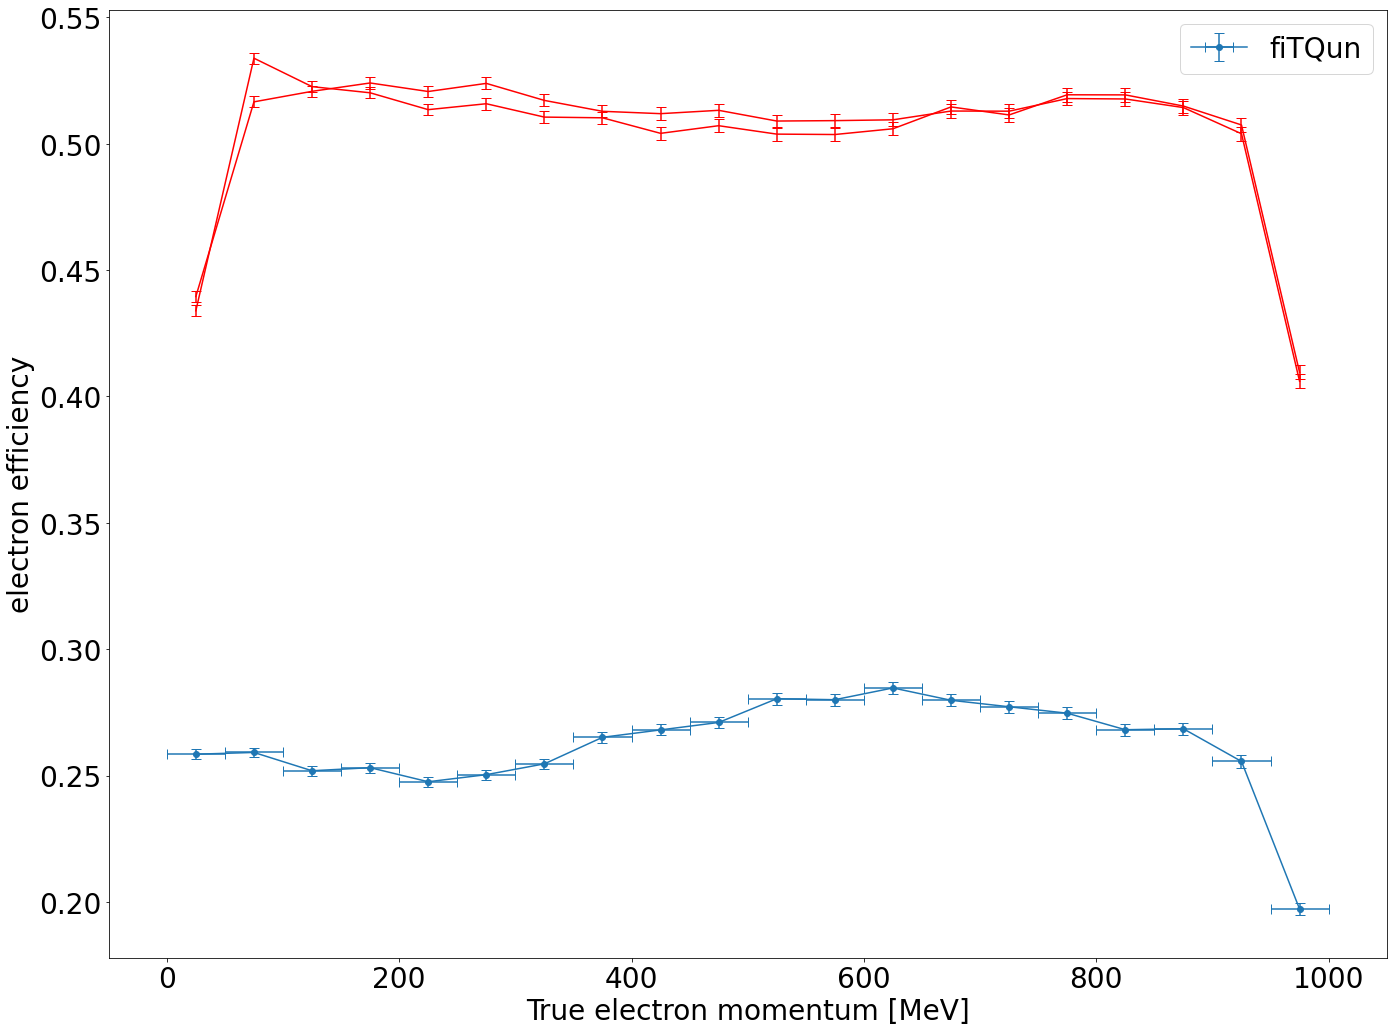

In [26]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (momentum[electrons] > l) & (momentum[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
#                 label=f'ResNet: {legend[i]}', fmt='-o', 
                capsize=5,color=colors[i])
    
ax.set_xlabel("True electron momentum [MeV]")
ax.set_ylabel("electron efficiency")
ax.legend()
fig.tight_layout()
#plt.savefig('2_class_results/true_momentum.jpg',bbox_inches='tight', dpi=150)

### Plot against reconstructed momentum

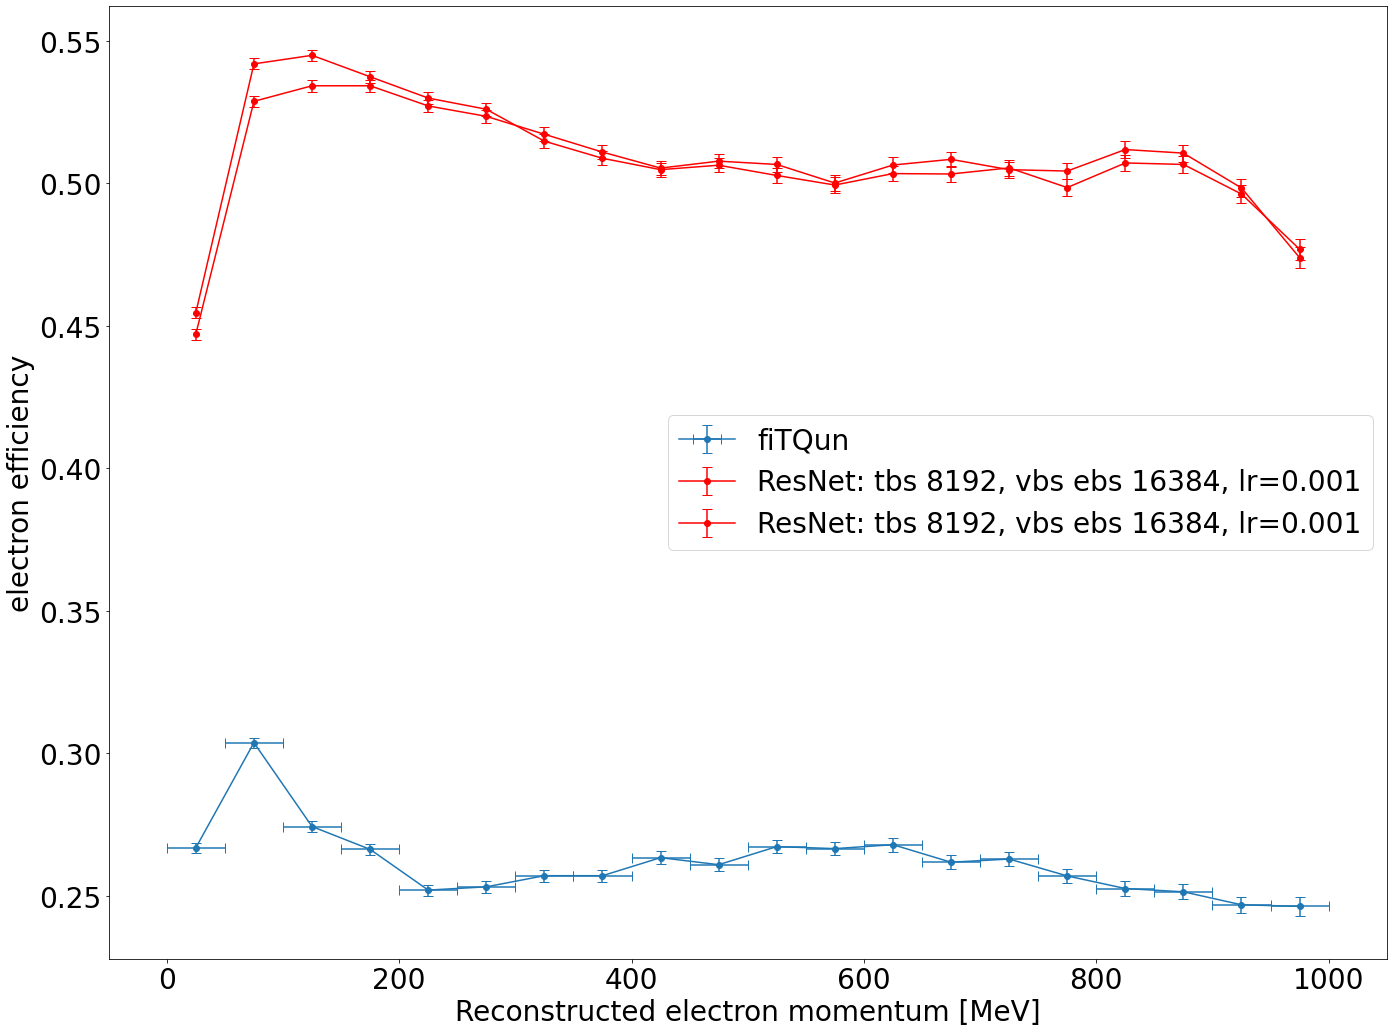

In [27]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (h5_reco_mom_e[electrons] > l) & (h5_reco_mom_e[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections])
                    for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
                label=f'ResNet: {legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Reconstructed electron momentum [MeV]")
ax.set_ylabel("electron efficiency")
ax.legend()
fig.tight_layout()
#plt.savefig('2_class_results/recon_momentum.jpg',bbox_inches='tight', dpi=150)

### Plot against zenith

In [28]:
zenith = h5_angles[:,0]

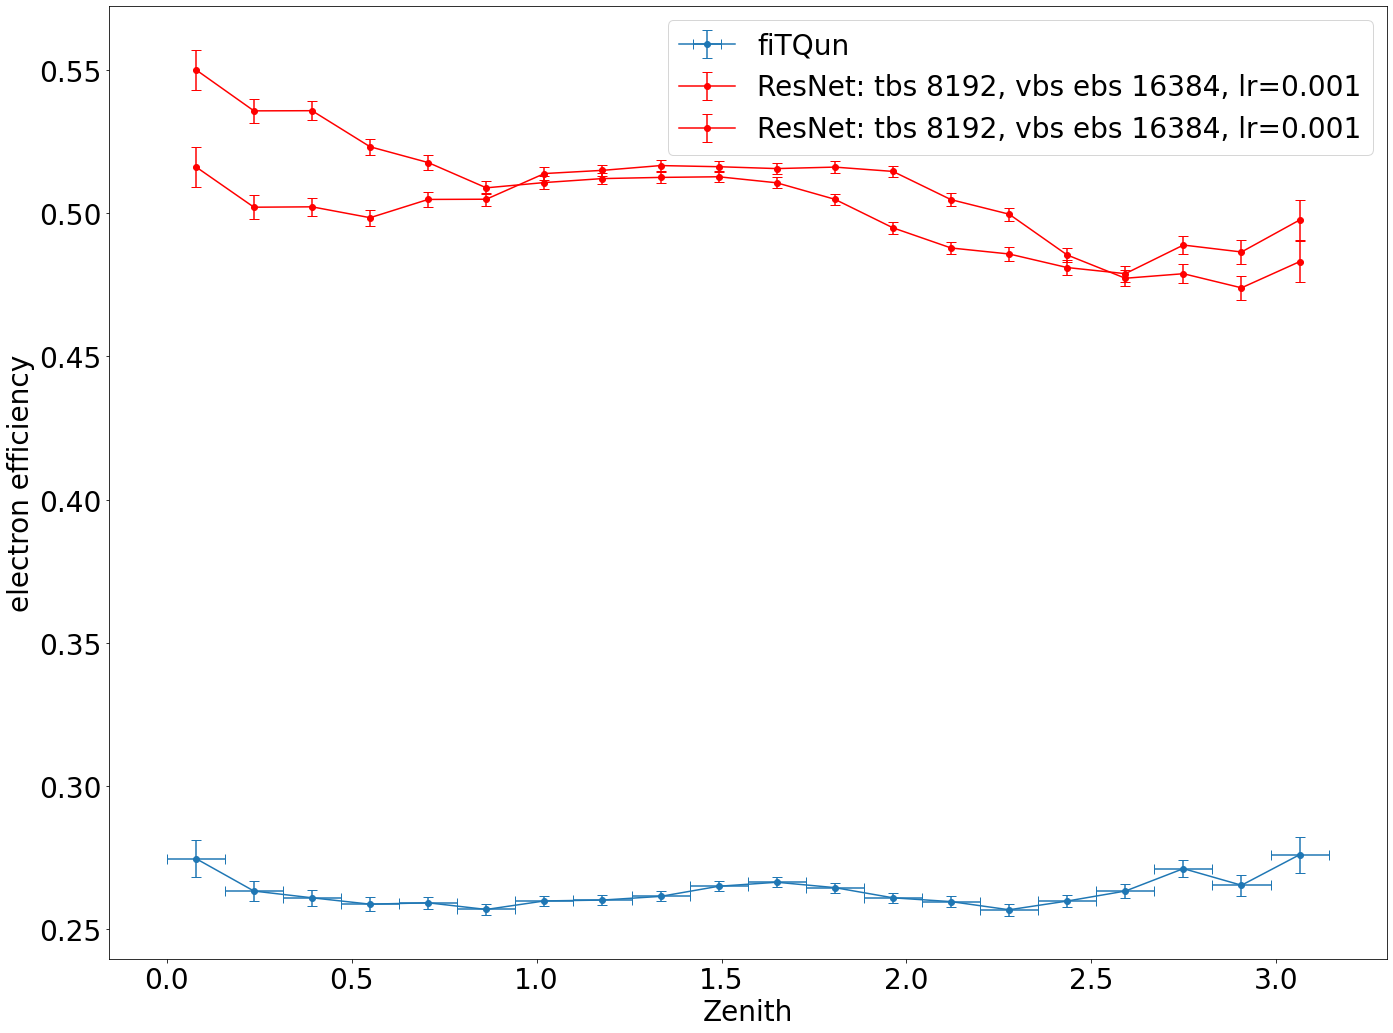

In [29]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = np.pi
plot_bin_width = np.pi/20
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (zenith[electrons] > l) & (zenith[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections])
                   for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                       for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i], 
                label=f'ResNet: {legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Zenith")
ax.set_ylabel("electron efficiency")
ax.legend()
fig.tight_layout()
#plt.savefig('2_class_results/zenith.jpg',bbox_inches='tight', dpi=150)

### Plot against azimuth

In [30]:
azimuth = h5_angles[:,1]

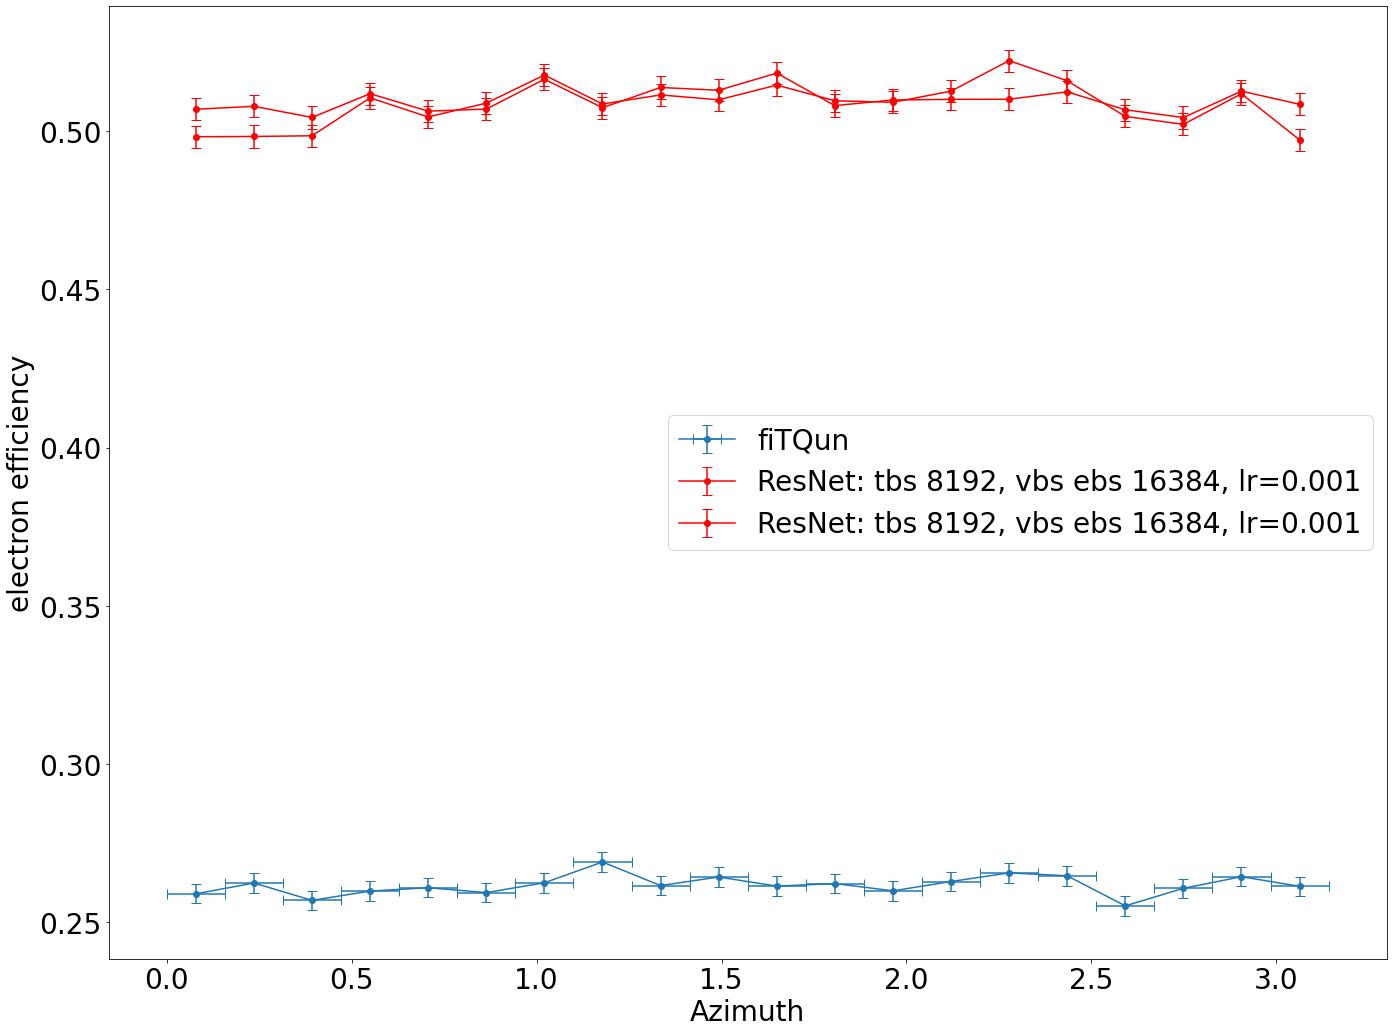

In [31]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = np.pi
plot_bin_width = np.pi/20
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (azimuth[electrons] > l) & (azimuth[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections])
                   for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                       for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
                label=f'ResNet: {legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Azimuth")
ax.set_ylabel("electron efficiency")
ax.legend()
fig.tight_layout()
#plt.savefig('2_class_results/azimuth.jpg',bbox_inches='tight', dpi=150)

In [32]:
# # define the bins for the plot
# plot_bin_low = 0
# plot_bin_high = np.pi
# plot_bin_width = np.pi/20
# plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
# plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
# plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# # for each particle, each bin, find the events in that bin
# plot_bin_selections = [
#     (azimuth[electrons] > l) & (azimuth[electrons] <= l+plot_bin_width)
#     for l in plot_bin_lows
# ]

# # for each particle, for each bin, calculate the efficiency rate and the error bar
# # for fiTQun
# eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
# eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# # for ResNet
# eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections])
#                    for i in range(N)]
# eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
#                        for i in range(N)]

# # plot the results
# fig, ax = plt.subplots(figsize=(20,15))
# ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
#             label='fiTQun', fmt='-o', capsize=5)

# for i in range(N):
#     ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
#                 label=f'ResNet: {legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
# ax.set_xlabel("Azimuth")
# ax.set_ylabel("electron efficiency")
# ax.legend()
# fig.tight_layout()
# # plt.savefig('e_vs_gamma/azimuth.jpg',bbox_inches='tight', dpi=150)